## Practical 8: Working with Text

The basics of Text Mining and NLP

Working with text is unquestionably *hard*. In fact, *conceptually* this
is probaly the most challenging practical of the term! But data
scientists are *always* dealing with text because so much of the data
that we collect (even more so thanks to the web) is not only text-based
(URLs are text!) but, increasingly, unstructured (social media posts,
tags, etc.). So while getting to grips with text is a challenge, it also
uniquely positions you with respect to the skills and knowledge that
other graduates are offering to employers.

> **🔗 Connections**
>
> If you plan to work with data post-graduation then you will *need* to
> become comfortable with Regular Expressions (aka. regexes). These are
> the focus of the [Patterns in
> Text](https://jreades.github.io/fsds/sessions/week7.html#lectures)
> lecture but they barely even scratch the surface of what regexes can
> do. They are *hard*, but they are powerful.

## 1. Setup

> **Difficulty Level: Low**
>
> But this is only because this has been worked out for you. Starting
> from sctach in NLP is *hard* so people try to avoid it as much as
> possible.

### 1.1 Required Modules

> **Note**
>
> Notice that the number of modules and functions that we import is
> steadily increasing week-on-week, and that for text processing we tend
> to draw on quite a wide range of utilies! That said, the three most
> commonly used are: `sklearn`, `nltk`, and `spacy`.

Standard libraries we’ve seen before.

In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import re
import math
import matplotlib.pyplot as plt

from pathlib import Path

This next is just a small utility function that allows us to output
Markdown (like this cell) instead of plain text:

In [2]:
from IPython.display import display_markdown

def as_markdown(head='', body='Some body text'):
    if head != '':
        display_markdown(f"##### {head}\n\n>{body}\n", raw=True)
    else:
        display_markdown(f">{body}\n", raw=True)

as_markdown('Result!', "Here's my output...")

### 1.2 Loading Data

> **🔗 Connections**
>
> Because I generally want each practical to stand on its own (unless
> I’m trying to make a *point*), I’ve not moved this to a separate
> Python file (e.g. `utils.py`, but in line with what we covered back in
> the lectures on \[Functions and
> Packages\]\[<span class="quarto-shortcode__-param"
> data-is-shortcode="1" data-value="var" data-raw="var"></span>
> <span class="quarto-shortcode__-param" data-is-shortcode="1"
> data-value="module.web" data-raw="module.web"></span>
> \]sessions/week3.html#lectures), this sort of thing is a good
> candidate for being split out to a separate file to simplify re-use.

Remember this function from last week? We use it to save downloading
files that we already have stored locally. But notice I’ve made some
small changes… what do these do to help the user?

In [3]:
from pathlib import Path
from requests import get
from functools import wraps

def check_cache(f):
    @wraps(f)
    def wrapper(src:str, dst:str, min_size=100) -> Path:
        if src.find('?') == -1:
            url = Path(src)
        else:
            url = Path(src[:src.find('?')])
        fn  = url.name  # Extract the filename
        dsn = Path(f"{dst}/{fn}") # Destination filename
        if dsn.is_file() and dsn.stat().st_size > min_size:
            print(f"+ {dsn} found locally!")
            return(dsn)
        else:
            print(f"+ {dsn} not found, downloading!")
            return(f(src, dsn))
    return wrapper

@check_cache
def cache_data(src:Path, dst:Path) -> str:
    """Downloads a remote file.
    
    The function sits between the 'read' step of a pandas or geopandas
    data frame and downloading the file from a remote location. The idea
    is that it will save it locally so that you don't need to remember to
    do so yourself. Subsequent re-reads of the file will return instantly
    rather than downloading the entire file for a second or n-th itme.
    
    Parameters
    ----------
    src : str
        The remote *source* for the file, any valid URL should work.
    dst : str
        The *destination* location to save the downloaded file.
        
    Returns
    -------
    str
        A string representing the local location of the file.
    """
      
    # Create any missing directories in dest(ination) path
    # -- os.path.join is the reverse of split (as you saw above)
    # but it doesn't work with lists... so I had to google how
    # to use the 'splat' operator! os.makedirs creates missing
    # directories in a path automatically.
    if not dst.parent.exists():
        dst.parent.mkdir(parents=True, exist_ok=True)
        
    # Download and write the file
    with dst.open(mode='wb') as file:
        response = get(src)
        file.write(response.content)
        
    print(' + Done downloading...')

    return dst.resolve()

> **Tip**
>
> For very large *non*-geographic data sets, remember that you can
> `use_cols` (or `columns` depending on the file type) to specify a
> subset of columns to load.

Load the main data set:

In [4]:
ymd  = '20250615'
city = 'London'
host = 'https://orca.casa.ucl.ac.uk'
url  = f'{host}/~jreades/data/{ymd}-{city}-listings.geoparquet'

In [5]:
gdf = gpd.read_parquet( cache_data(url, Path('data/geo')), 
          columns=['geometry', 'listing_url', 'name', 
                   'description', 'amenities', 'price']).to_crs('epsg:27700')

print(f"gdf has {gdf.shape[0]:,} rows and CRS is {gdf.crs.name}.")

+ data/geo/20250615-London-listings.geoparquet found locally!
gdf has 82,856 rows and CRS is OSGB36 / British National Grid.

Load supporting Geopackages:

In [6]:
ddir  = Path('data/geo') # destination directory
spath = 'https://github.com/jreades/fsds/blob/master/data/src/' # source path

boros = gpd.read_file( cache_data(spath+'Boroughs.gpkg?raw=true', ddir) )
water = gpd.read_file( cache_data(spath+'Water.gpkg?raw=true', ddir) )
green = gpd.read_file( cache_data(spath+'Greenspace.gpkg?raw=true', ddir) )

print('Done.')

+ data/geo/Boroughs.gpkg found locally!
+ data/geo/Water.gpkg found locally!
+ data/geo/Greenspace.gpkg found locally!
Done.

## 2. Cleaning Text

In a full text-mining application I would spend a lot more time on this
stage: sampling, looking at descriptions in full, performing some
initial analyses and then coming back with a deeper understanding of the
data to make further changes to the analysis.

Regardless, it’s helpful to have a sense of what data look like before
trying to do something with them, but by default pandas truncates quite
a lot of output to keep it from overwhelming the display. For text
processing, however, you should probably change the amount of preview
text provided by pandas using the available options. *Note*: there are
lots of other options that you can tweak in pandas.

In [7]:
print(f"Default maximum column width: {pd.options.display.max_colwidth}") # What's this currently set to?
pd.options.display.max_colwidth=250   # None = no maximum column width (you probably don't want to leave it at this)
print(f"Now maximum column width set to: {pd.options.display.max_colwidth}")

Default maximum column width: 50
Now maximum column width set to: 250

### 2.1 The Description Field

> **Difficulty level: Moderate, because of the questions.**

To explore the description field properly you’ll need to filter out any
NA/NaN descriptions before sampling the result. *Hint*: you’ll need to
think about boolean NOT (`~`) applied to a field where the only test we
have is *is NA*.

##### 2.1.0.1 Question

In [ ]:
gdf[???].sample(5, random_state=42)[['description']]

What do you notice about the above? Are they simple text? Are there
patterns or problems? Are there characters that represent things other
than words and simple punctuation?

##### 2.1.0.2 Questions

-   What patterns can you see that might need ‘dealing with’ for
    text-mining to work?
-   What non-text characters can you see? (Things *other* than A-Z, a-z,
    and simple punctuation!)

### 2.2 The Amenities Field

> **Difficulty level: Moderate, because of the questions.**

This field presents a subtle issue that might not be obvious here:

In [10]:
gdf.amenities.sample(5, random_state=42)

56034    ["Dining table", "Paid high chair - available upon request", "Bathtub", "Cooking basics", "First aid kit", "Air conditioning", "Clothing storage: closet", "Bed linens", "Carbon monoxide alarm", "Kitchen", "Shampoo", "Coffee maker: Nespresso", "Sh...
25066              ["Kitchen", "Elevator", "Bathtub", "Refrigerator", "Microwave", "Stove", "Cooking basics", "Hair dryer", "Dishes and silverware", "Dedicated workspace", "Heating", "Hot water kettle", "Iron", "Wifi", "Hot water", "Hangers", "TV", "Washer"]
12382    ["Dining table", "Free parking on premises", "Cooking basics", "Carbon monoxide alarm", "Bed linens", "Clothing storage: closet and dresser", "Free dryer \u2013 In unit", "Kitchen", "Shampoo", "Host greets you", "Shower gel", "Dedicated workspace...
72986                                                                                                                      ["Hangers", "Pets allowed", "Heating", "Essentials", "Shampoo", "Elevator", "Smoke alarm", "Kitchen"

But look what happens now, can you see the issue a little more easily?

In [11]:
gdf.amenities.iloc[0][:25]

'["Kitchen", "Free parking'

##### 2.2.0.1 Questions

-   What’s the implicit format of the Amenities columns?
-   How could you represent the data contained in the column?

### 2.3 Remove NaN Values

I would be wary of doing what I do below in a ‘proper’ application
without some careful research, but to make our lives easier, we’re going
to drop rows where one of the two key columns (Description, Amenities)
for this practical is `NaN` because it will simplify the steps below. In
reality, I would spend quite a bit more time investigating which values
are NaN and why before simply dropping them.

##### 2.3.0.1 Question

How do you drop all rows where *either* the description or amenities (or
both) are `NaN`:

In [ ]:
gdf = gdf.dropna(???)
print(f"Now gdf has {gdf.shape[0]:,} rows.")

You should get that there are `80,917` rows.

## 3. Regexes in Pandas

> **🔗 Connections**
>
> We’re building on the work done in [Practical
> 7](https://jreades.github.io/fsds/sessions/week7.html#practical), but
> making use now of the lecture on [Patterns in
> Text](https://jreades.github.io/fsds/sessions/week6.html#pre-recorded-lectures))
> to quickly sort through the listings.

There is a *lot* that can be done with Regular Expressions to identify
relevant records in textual data and we’re going to use this as a
starting point for the rest of the analysis. I would normally consider
the regexes below a ‘first pass’ at the data and would look very
carefully at the output of the TF/IDF vectorizer, Count vectorizer
and/or LDA to see if I could improve my regexes for further cycles of
analysis…

The main gain here is that regexes are *much* faster than using the full
NLP (Natural Language Processing) pipeline on the *full* data set each
time. As an alternative, you could develop the pipeline using a random
subsample of the data and then process the remaining records
sequentially – in this context there is no justification for doing that,
but with a larger corpus it might make sense.

### 3.1 Using Strings in Pandas

We’ve not done much formally with text data in Pandas, so let’s have a
quick look at what’s possible. Most of these operations are accessed by
calling on the `.str` accessor and you can read *[allllllll about
it](https://pandas.pydata.org/docs/user_guide/text.html)*.

#### 3.1.1 Trimming

In [15]:
# From the pandas documentation
idx = pd.Index([" jack", "jill ", " jesse ", "frank"])

print(idx)
print(idx.str.strip())
print(idx.str.lstrip())
print(idx.str.rstrip())

Index([' jack', 'jill ', ' jesse ', 'frank'], dtype='object')
Index(['jack', 'jill', 'jesse', 'frank'], dtype='object')
Index(['jack', 'jill ', 'jesse ', 'frank'], dtype='object')
Index([' jack', 'jill', ' jesse', 'frank'], dtype='object')

#### 3.1.2 Lower/Upper Case

In [16]:
gdf.sample(3, random_state=42).description.str.lower()

31167    welcome to the stylish 1br 1bath apartment located just few minutes from the bustling streets of central london. whether shopping along oxford street, catching a west end show or sampling local cuisine, it will be the perfect starting point for y...
79360    ✔ lovely house w/ garden nicely nestled in marylebone <br />✔ 1345 ft2 | 125 m2 <br />✔ 3 bedrooms <br />✔ 2 bathrooms <br />✔ well-equipped kitchen <br />✔ backyard patio <br />✔ next to regent's park <br />✔ 10-minute walk to the sherlock holme...
25654    enjoy a stylish experience at this centrally-located flat. supermarkets, a plethora of bars, restaurants and cafes on your doorstep and only a 7 minutes walk to angel station (1 stop from kingcross station) which will get you anywhere you need to...
Name: description, dtype: object

In [17]:
gdf.sample(3, random_state=42).description.str.upper()

31167    WELCOME TO THE STYLISH 1BR 1BATH APARTMENT LOCATED JUST FEW MINUTES FROM THE BUSTLING STREETS OF CENTRAL LONDON. WHETHER SHOPPING ALONG OXFORD STREET, CATCHING A WEST END SHOW OR SAMPLING LOCAL CUISINE, IT WILL BE THE PERFECT STARTING POINT FOR Y...
79360    ✔ LOVELY HOUSE W/ GARDEN NICELY NESTLED IN MARYLEBONE <BR />✔ 1345 FT2 | 125 M2 <BR />✔ 3 BEDROOMS <BR />✔ 2 BATHROOMS <BR />✔ WELL-EQUIPPED KITCHEN <BR />✔ BACKYARD PATIO <BR />✔ NEXT TO REGENT'S PARK <BR />✔ 10-MINUTE WALK TO THE SHERLOCK HOLME...
25654    ENJOY A STYLISH EXPERIENCE AT THIS CENTRALLY-LOCATED FLAT. SUPERMARKETS, A PLETHORA OF BARS, RESTAURANTS AND CAFES ON YOUR DOORSTEP AND ONLY A 7 MINUTES WALK TO ANGEL STATION (1 STOP FROM KINGCROSS STATION) WHICH WILL GET YOU ANYWHERE YOU NEED TO...
Name: description, dtype: object

#### 3.1.3 Replacing

In [18]:
gdf.sample(3, random_state=42).description.str.replace(r' ','_',regex=False)

31167    Welcome_to_the_stylish_1BR_1Bath_apartment_located_just_few_minutes_from_the_bustling_streets_of_central_London._Whether_shopping_along_Oxford_Street,_catching_a_West_End_show_or_sampling_local_cuisine,_it_will_be_the_perfect_starting_point_for_y...
79360    ✔_Lovely_house_w/_garden_nicely_nestled_in_Marylebone_<br_/>✔_1345_ft2_|_125_m2_<br_/>✔_3_bedrooms_<br_/>✔_2_bathrooms_<br_/>✔_Well-equipped_kitchen_<br_/>✔_Backyard_patio_<br_/>✔_Next_to_Regent's_Park_<br_/>✔_10-minute_walk_to_The_Sherlock_Holme...
25654    Enjoy_a_stylish_experience_at_this_centrally-located_flat._Supermarkets,_a_plethora_of_bars,_restaurants_and_cafes_on_your_doorstep_and_only_a_7_minutes_walk_to_Angel_station_(1_stop_from_Kingcross_station)_which_will_get_you_anywhere_you_need_to...
Name: description, dtype: object

In [19]:
gdf.sample(3, random_state=42).description.str.replace(r'\W','',regex=True)

31167                                     Welcometothestylish1BR1BathapartmentlocatedjustfewminutesfromthebustlingstreetsofcentralLondonWhethershoppingalongOxfordStreetcatchingaWestEndshoworsamplinglocalcuisineitwillbetheperfectstartingpointforyouradventures
79360    LovelyhousewgardennicelynestledinMarylebonebr1345ft2125m2br3bedroomsbr2bathroomsbrWellequippedkitchenbrBackyardpatiobrNexttoRegentsParkbr10minutewalktoTheSherlockHolmesMuseumbrBakerStreetStationRegentsParkStationarebothundera10minutewalkawaybrAne...
25654                                                   EnjoyastylishexperienceatthiscentrallylocatedflatSupermarketsaplethoraofbarsrestaurantsandcafesonyourdoorstepandonlya7minuteswalktoAngelstation1stopfromKingcrossstationwhichwillgetyouanywhereyouneedtogo
Name: description, dtype: object

#### 3.1.4 Splitting

In [20]:
gdf.sample(3, random_state=42).amenities.str.split(r',')

31167    [["Microwave",  "Hot water kettle",  "Body soap",  "Cleaning products",  "Kitchen",  "Bathtub",  "Dishes and silverware",  "Shower gel",  "Dining table",  "Heating",  "Self check-in",  "Long term stays allowed",  "Washer",  "Smoke alarm",  "Oven"...
79360    [["Bathtub",  "Cooking basics",  "First aid kit",  "Carbon monoxide alarm",  "Bed linens",  "Kitchen",  "Shampoo",  "Host greets you",  "Backyard",  "Coffee maker",  "Stove",  "Room-darkening shades",  "Hair dryer",  "Private entrance",  "Oven", ...
25654    [["Bathtub",  "Dishes and silverware",  "Carbon monoxide alarm",  "Central heating",  "Dedicated workspace",  "Essentials",  "Lockbox",  "Self check-in",  "Iron",  "Hot water",  "Washer",  "Smoke alarm",  "Kitchen",  "Hair dryer",  "Portable fans...
Name: amenities, dtype: object

In [21]:
gdf.sample(3, random_state=42).amenities.str.split(r',', expand=True)

3 rows × 34 columns

#### 3.1.5 Indexing

In [22]:
gdf.sample(3, random_state=42).description.str[:25]

31167    Welcome to the stylish 1B
79360    ✔ Lovely house w/ garden 
25654    Enjoy a stylish experienc
Name: description, dtype: object

#### 3.1.6 Extraction

In [23]:
# For some reason this doesn't take regex=True
gdf.sample(3, random_state=42).description.str.extract(r'stylish (?P<detail>\w+)')

#### 3.1.7 Putting it Together

In [24]:
gdf.sample(3, random_state=42).amenities.str.upper().str.replace(r'(?:\"|\[|\])', '', regex=True).str.split(r'\s*,\s*', regex=True, expand=True)

Or you could also tackle it this way:

In [25]:
gdf.sample(3, random_state=42).amenities.str.upper().str.replace(r'(?:\"|\[|\])', '', regex=True).str.get_dummies(sep=r',')

> **Check Your Data!**
>
> The `get_dummies` method works better than I expected! I assumed it
> would struggle with the `[` and `]` at the start and end of the
> string; however, I *think* what’s happening is that these are not
> allowed characters in a column name so they’re simply dropped from the
> expansion.
>
> What’s nice about the `get_dummies` approach from an analytical
> standpoint is that it deals with the issue that the amenities are not
> all listed in the same order in every listing. So some might lead with
> the size of the TV, while other listings (with equally large
> televisions) lead with the views. Converting all of these to dummies
> automatically ‘sorts’ them so that we can ask questions like ‘which
> listings have a TV *and* a great view?’

### 3.2 Selecting Data

In the same way that we can use operators like `<` and `==` to select
rows from a data frame, we also have the output of operations like
`contains` available. So here’s an example:

In [26]:
gdf[
    gdf.description.str.contains(r'Flat', regex=False, flags=re.IGNORECASE)
].sample(3, random_state=42)[['description']]

## 4. Selecting Luxury Listings

> **Difficulty level: Hard, because of the regular expression and
> questions.**

I would like you to find listings that *might* (on the basis of word
choice) indicate ‘luxury’ accommodation.

#### 4.0.1 Create the Regular Expression

You should start with variations on ‘luxury’ (i.e. luxurious, luxuriate,
…) and work out a **single regular expression** that works for
variations on this *one* word. **Later**, I would encourage you to come
back to this and consider what other words might help to signal
‘luxury’… perhaps words like ‘stunning’ or ‘prestigious’? Could you add
those to the regex as well?

*Hints*: this is a toughy, but…

1.  All regular expressions work best using the `r'...'` (which means
    raw string) syntax.
2.  You need to be able to *group* terms. Recall, however, that in
    Python a ‘group’ of the form `r'(some text)'` refers to matching
    (`some text` will be ‘memoized’/remembered), whereas what you need
    here is a “non-capturing group” of the **positive lookahead** type.
    That’s a Google clue right there, but you’ve also seen this in the
    lecture.

In fact, in my real-world applications you might even need more than one
group/non-capturing group in a *nested* structure.

##### 4.0.1.1 Question

In [ ]:
gdf[
    gdf.description.str.contains(
        r'???', 
        regex=True, flags=re.IGNORECASE) # <-- The regex
].sample(3, random_state=42)[['description']]

#### 4.0.2 Apply it to Select Data

Assign it to a new data frame called `lux`:

##### 4.0.2.1 Question

In [ ]:
lux = gdf[
    gdf.description.str.contains(
        r'???', 
        regex=True, flags=re.IGNORECASE)
].copy()
lux.to_parquet(os.path.join('data','clean','luxury.geoparquet'))
print(f"Found {lux.shape[0]:,} records for 'luxury' flats")

You should get that there are `8,144` rows.

#### 4.0.3 Plot the Data

Now we are going to create a more complex plot that will give space to
both the spatial and price distributions using `subplot2grid`.

In [32]:
help(plt.subplot2grid)

Notice that there are two ways to create the plot specified above. I
chose route 1, but in some ways route 2 (where you specify a `gridspec`
object and *then* add the axes might be a bit simpler to work out if
you’re starting from scratch.

The critical thing here is to understand how we’er initialising a plot
that has **4 rows** and **1 column** even though it is only showing **2
plots**. What we’re going to do is set the *first* plot to span **3
rows** so that it takes up 75% of the plot area (3/4), while the
*second* plot only takes up 25% (1/4). They will appear one above the
other, so there’s only 1 column. Here’s how to read the key parts of
`subplot2grid`:

-   `nrows` – how many rows *of plots* in the figure.
-   `ncols` – how many columns *of plots* in the figure.
-   `row` – what row of the figure does *this* plot start on (0-indexed
    like a list in Python).
-   `col` – what column of the figure does *this* plot start on
    (0-indexed like a list in Python).
-   `rowspan` – how many rows of the figure does *this* plot span (*not*
    0-indexed because it’s not list-like).
-   `colspan` – how many columns of the figure does *this* plot span
    (*not* 0-indexed because it’s not list-like).

Every time you call `subplot2grid` you are initialising a new
axis-object into which you can then draw with your geopackage or pandas
plotting methods.

##### 4.0.3.1 Question

In [ ]:
f,ax = plt.subplots(1,1,figsize=(9,6))
ax.remove()

# The first plot 
ax1 = plt.subplot2grid((4, 1), (???), rowspan=???)
boros.plot(edgecolor='red', facecolor='none', linewidth=1, alpha=0.75, ax=ax1)
lux.plot(markersize=2, column='price', cmap='viridis', alpha=0.2, scheme='Fisher_Jenks_Sampled', ax=ax1)

ax1.set_xlim([500000, 565000])
ax1.set_ylim([165000, 195000]);

# The second plot
ax2 = plt.subplot2grid((???), (???), rowspan=1)
lux.price.plot.hist(bins=250, ax=ax2)

plt.suptitle("Listings Advertising Luxury") # <-- How does this differ from title? Change it and see!
plt.tight_layout() # <-- Try creating the plot *without* this to see what it changes
plt.show()

Your result should look similar to:

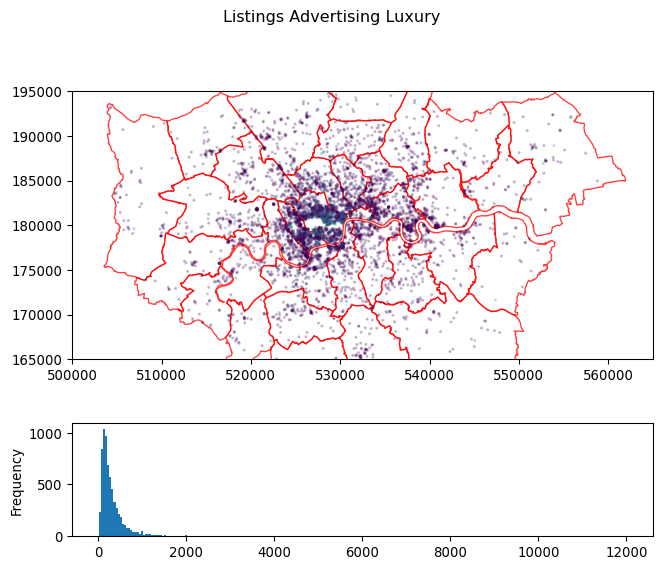

##### 4.0.3.2 Question

-   What does `suptitle` do and how is it different from `title`? Could
    you use this as part of your plot-making process?
-   What does `tight_layout` do?

## 5. Selecting Budget Listings

> **Difficulty level: Easy, because you’ve worked out the hard bits
> already.**

#### 5.0.1 Create the Regular Expression

What words can you think of that might help you to spot affordable and
budget accommodation? Start with just a couple of words and then I would
encourage you to consider what *other* words might help to signal
‘affordability’… perhaps words like ‘cosy’ or ‘charming’ and then think
about how you could you add those to the regex?

*Hints*: this just builds on what you did above with one exception:

1.  I’d try adding word boundary markers to the regex (`\b`) where
    appropriate…

##### 5.0.1.1 Question

In [ ]:
gdf[
    gdf.description.str.contains(
        ???, 
        regex=True, flags=re.IGNORECASE)
].sample(5, random_state=42)[['description']]

#### 5.0.2 Apply it to Select Data

##### 5.0.2.1 Question

In [ ]:
aff = gdf[
    gdf.description.str.contains(
        ???, 
        regex=True, flags=re.IGNORECASE)
].copy()
aff.to_parquet(os.path.join('data','clean','affordable.geoparquet'))
print(f"There are {aff.shape[0]:,} rows flagged as 'affordable'.")

You should get that there are `6,295` rows.

#### 5.0.3 Plot the Data

In [41]:
f,ax = plt.subplots(1,1,figsize=(8,6))
ax.remove()

# The first plot
ax1 = plt.subplot2grid((4, 1), (0, 0), rowspan=3)
boros.plot(edgecolor='red', facecolor='none', linewidth=1, alpha=0.75, ax=ax1)
aff.plot(markersize=2, column='price', cmap='viridis', alpha=0.2, scheme='Fisher_Jenks_Sampled', ax=ax1)

ax1.set_xlim([500000, 565000])
ax1.set_ylim([165000, 195000]);

# The second plot
ax2 = plt.subplot2grid((4, 1), (3, 0), rowspan=1)
aff.price.plot.hist(bins=100, ax=ax2)

plt.suptitle("Listings Advertising Affordability")
plt.tight_layout()
#plt.savefig("Affordable_Listings.png", dpi=150)

Your map should look something like this:

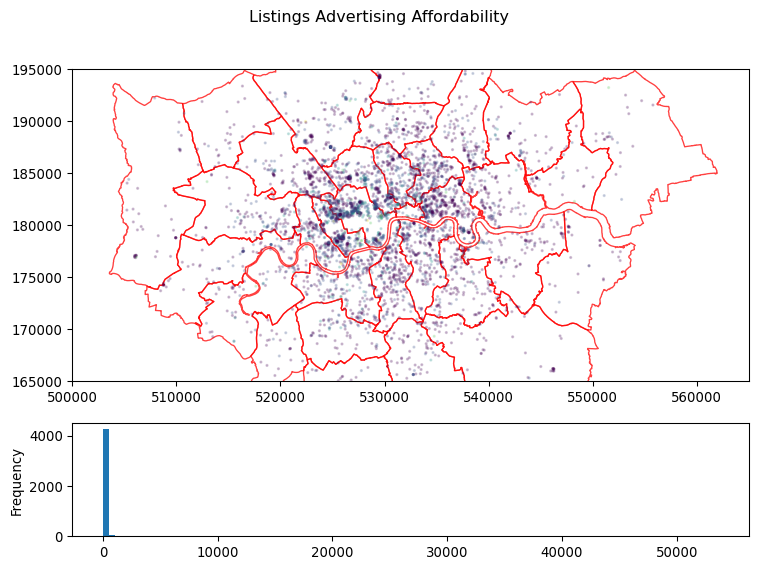
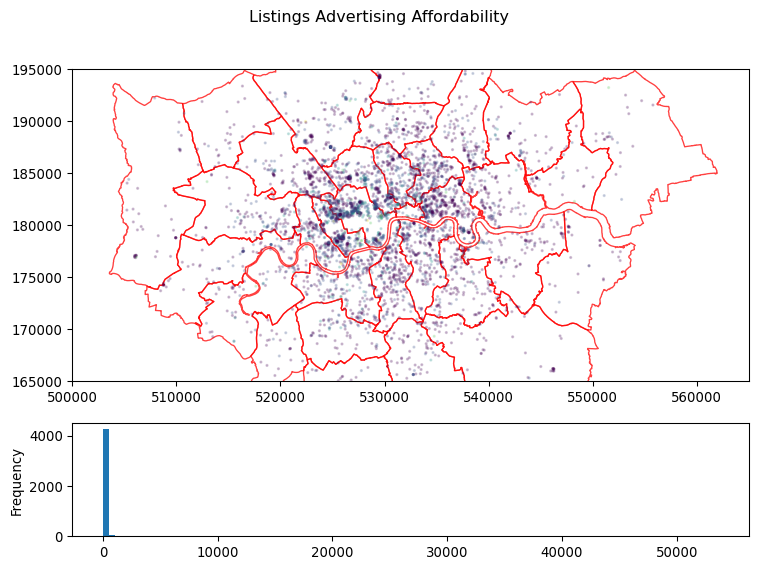

#### 5.0.4 Questions

-   Do you think that this is a *good* way to select affordable options?
-   Do you understand what `dpi` means and how `savefig` works?
-   Copy the code from above but modify it to constrain the histogram on
    a more limited distribution by *filtering* out the outliers *before*
    drawing the plot. I would copy the cell above to one just below here
    so that you keep a working copy available and can undo any changes
    that break things.

## 6. Selecting ‘Bluespace’

> **Difficulty level: Medium, because you’re still learning about
> regexes.**

Now see if you can work out a regular expression to find accommodation
that emphasises accessibility to the Thames and other ‘blue spaces’ as
part of the description? One thing you’ll need to tackle is that some
listings seem to say something about Thameslink and you wouldn’t want
those be returned as part of a regex looking for *rivers*. So by way of
a hint:

-   You probably need to think about the Thames, rivers, and water.
-   These will probably be *followed* by a qualifier like a ‘view’
    (e.g. Thames-view) or a front (e.g. water-front).
-   But you need to rule out things like “close the Thameslink station…”

#### 6.0.1 Create the regular Expression

##### 6.0.1.1 Question

In [ ]:
gdf[
    gdf.description.str.contains(
        ???, 
        regex=???, flags=???)
].sample(5, random_state=42)[['description']]

#### 6.0.2 Apply it to the Select Data

##### 6.0.2.1 Question

In [ ]:
bluesp = gdf[
    (gdf.description.str.contains(???, regex=True, flags=re.IGNORECASE)) |
    (gdf.description.str.contains(???, regex=True, flags=re.IGNORECASE))
].copy()
bluesp.to_parquet(os.path.join('data','clean','bluespace.geoparquet'))
print(f"Found {bluesp.shape[0]:,} rows.")

You should get that there are `347` rows.

#### 6.0.3 Plot the Data

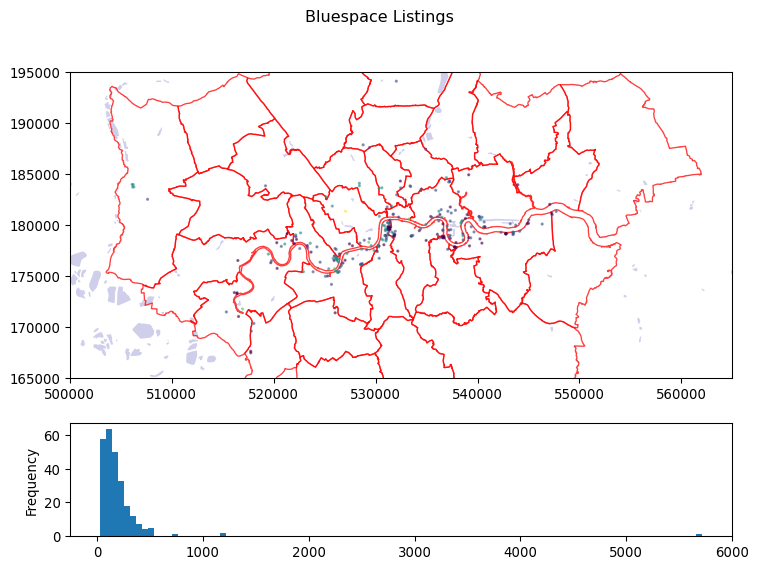

In [49]:
f,ax = plt.subplots(1,1,figsize=(8,6))
ax.remove()

# The first plot
ax1 = plt.subplot2grid((4, 1), (0, 0), rowspan=3)
water.plot(edgecolor='none', facecolor=(.25, .25, .7, .25), ax=ax1)
boros.plot(edgecolor='red', facecolor='none', linewidth=1, alpha=0.75, ax=ax1)
bluesp.plot(markersize=2, column='price', cmap='viridis', alpha=0.5, scheme='Fisher_Jenks_Sampled', ax=ax1)

ax1.set_xlim([500000, 565000])
ax1.set_ylim([165000, 195000]);

# The second plot
ax2 = plt.subplot2grid((4, 1), (3, 0), rowspan=1)
bluesp.price.plot.hist(bins=100, ax=ax2)

plt.suptitle("Bluespace Listings")
plt.tight_layout()
plt.show()

#### 6.0.4 Questions

-   How else might you select listings with a view of the Thames or
    other bluespaces?

## 7. Real-World Examples

Here are some *parts* of real-world regex code that I’m using to extract
the main elements of addresses in a data set that I’m working on. There
are four *more* regular expressions that I then compile into one monster
regex, but see if you can make sense of what kinds of text they will
match.

In [50]:
alocation = re.compile(r'''
  \b(?P<flat>
      (?:The)?
      (?:
          (?:Basement|Lower|Ground|Upper|First|Second|Third|Fourth|Fifth|And)
          \b\s*
      )+
      (?:Floors?)?
  )\b\s*
''', re.X | re.IGNORECASE)

# Regex to match ranges in addresses
# This regex matches ranges like '1-5', '2 to 4', '3–7', '10/12', etc.
is_range = re.compile(r'''
    \b(
        (?:
            \d+[A-Ha-h]|  # Note that the order of the conditions
            [A-Ha-h]\d+|  # here matters. If you put \d+ *first*
            \d+|          # then '2b' will never match because '2'
            [A-Ha-h]      # will always be pulled out before.
        )
        \s*
        (?:-|–|—|[Tt]o|/)
        \s*
        (?:
            \d+[A-Ha-h]|
            [A-Ha-h]\d+|
            \d+|
            [A-Ha-h]
        )
    )\b
''', re.X)

One way to do that is write some simple ‘test cases’ and see what
happens! Notice that, in the `alocation` regex we have a “named capture
group”. See if you can *add* this to the `is_range` regular expression…
you might want to duplicate the code block above so that you have a
‘clean’ copy to revert to if you break the regular expressions and
aren’t sure why.

In [51]:
cases = [
    'Lower Ground Floor Flat', 'Flat 2b', 
    '#34', 'Basement and Ground Floor',
    '1b-3c Hoxton Square']

for c in cases:
    print(f"Case: {c}")
    m1 = alocation.search(c)
    m2 = is_range.search(c)
    if m1:
        print("\tGot a match on alocation.")
        print(f"\tMatch was: '{m1.group('flat')}'")
    if m2:
        print("\tGot a match on is_range")
        print(f"\tMatch was: '{m2.group(1)}'")
    if not(m1 or m2):
        print("\tNo match.")  
    print()

## 8. Resources

There is a lot more information out there, including a [whole
book](https://www.nltk.org/book/) and your standard [O’Reilly
text](http://www.datascienceassn.org/sites/default/files/Natural%20Language%20Processing%20with%20Python.pdf).

And some more useful links:

-   [Pandas String Contains
    Method](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.contains.html)
-   [Using Regular Expressions with
    Pandas](https://kanoki.org/2019/11/12/how-to-use-regex-in-pandas/)
-   [Summarising Chapters from Frankenstein using
    TF/IDF](https://towardsdatascience.com/using-tf-idf-to-form-descriptive-chapter-summaries-via-keyword-extraction-4e6fd857d190)